In [1]:
%matplotlib inline


Adversarial Example Generation
==============================




Fast Gradient Sign Attack
-------------------------




In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

Implementation
--------------


Inputs
---------

There are only three inputs for this tutorial, and are defined as
follows:

-  **epsilons** 
-  **pretrained_model** 
-  **use_cuda** 




In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
device.type

'cuda'

FGSM Attack


\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}




In [6]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [7]:
# Basic Iterative Method attack code and Projected Gradient 
def bim_attack(model, criterion, image, label, epsilon, alpha, iters=0):

    img_bim = torch.tensor(image.data, requires_grad=True)    
    
    if(iters==0):
        iters = int(np.ceil(min(epsilon+4, 1.25*epsilon)))
    else:
        if device.type == "cuda":
            delta_init = torch.from_numpy(np.random.uniform(-epsilon, epsilon, image.shape)).type(torch.cuda.FloatTensor)
        else:
            delta_init = torch.from_numpy(np.random.uniform(-epsilon, epsilon, image.shape)).type(torch.FloatTensor)
        img_bim = torch.tensor(img_bim.data+delta_init, requires_grad = True)
        clipped_delta = torch.clamp(img_bim.data-image.data, -epsilon, epsilon)
        img_bim = torch.tensor(image.data+clipped_delta, requires_grad = True)

    
    for i in range(iters):
        output = model(img_bim)
        loss = criterion(output, label)
        loss.backward()
        delta = alpha*torch.sign(img_bim.grad.data)
        img_bim = torch.tensor(img_bim.data + delta, requires_grad=True)
        clipped_delta = torch.clamp(img_bim.data-image.data, -epsilon, epsilon)
        img_bim = torch.tensor(image.data+clipped_delta, requires_grad = True)
    return img_bim

In [8]:

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    cf_mat = np.zeros([10,10])
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        cf_mat[final_pred.item(),target.item()]+=1
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples,cf_mat

In [9]:
def test_bim( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    cf_mat = np.zeros([10,10])    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Criteria
        criterion = nn.CrossEntropyLoss()

        # Zero all existing gradients
        model.zero_grad()

       

        # Call FGSM Attack
        alpha = epsilon/2
#         print("target: ",target)
#         print("made up target: ",torch.tensor([1]).cuda())
        t = torch.tensor([1]).cuda()
        perturbed_data = bim_attack(model, criterion, data, t, epsilon, alpha)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        cf_mat[final_pred.item(),target.item()]+=1
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples,cf_mat

In [10]:
def test_pgd( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    cf_mat = np.zeros([10,10])
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Criteria
        criterion = nn.CrossEntropyLoss()

        # Zero all existing gradients
        model.zero_grad()

       

        # Call FGSM Attack
        alpha = epsilon/2
        perturbed_data = bim_attack(model, criterion, data, target, epsilon, alpha, iters=1)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        cf_mat[final_pred.item(),target.item()]+=1
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, cf_mat

Run Attack

The last part of the implementation is to actually run the attack. Here,
we run a full test step for each epsilon value in the *epsilons* input.
For each epsilon we also save the final accuracy and some successful
adversarial examples to be plotted in the coming sections. Notice how
the printed accuracies decrease as the epsilon value increases. Also,
note the $\epsilon=0$ case represents the original test accuracy,
with no attack.




Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


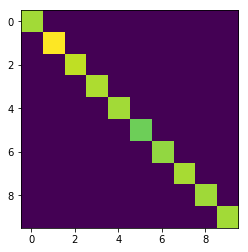

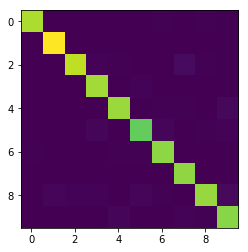

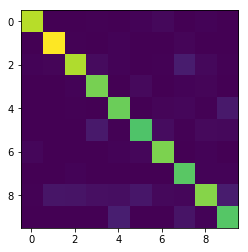

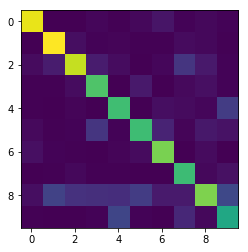

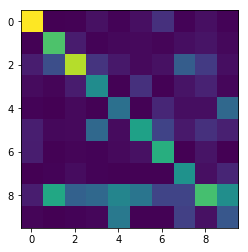

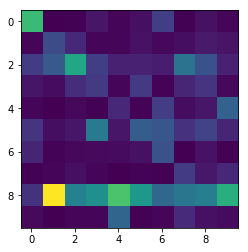

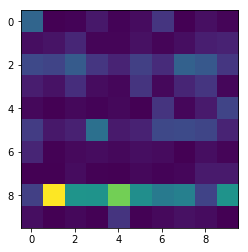

In [11]:
import cv2
accuracies_fgsm = []
examples_fgsm = []
cf_mats = []
# Run test for each epsilon
for eps in epsilons:
    acc, ex,cf_mat = test(model, device, test_loader, eps)
    accuracies_fgsm.append(acc)
    plt.figure()
    plt.imshow(cf_mat)
#     plt.imsave("cfmat_fgsm_{}.png".format(eps),cv2.resize(cf_mat,dsize=(256,256),interpolation=cv2.INTER_AREA))
    examples_fgsm.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9757 / 10000 = 0.9757
Epsilon: 0.1	Test Accuracy = 9701 / 10000 = 0.9701
Epsilon: 0.15	Test Accuracy = 9622 / 10000 = 0.9622
Epsilon: 0.2	Test Accuracy = 9496 / 10000 = 0.9496
Epsilon: 0.25	Test Accuracy = 9300 / 10000 = 0.93
Epsilon: 0.3	Test Accuracy = 9036 / 10000 = 0.9036


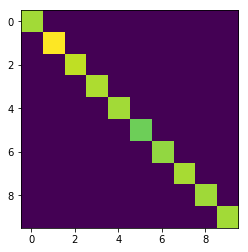

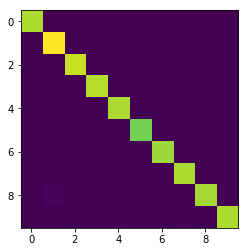

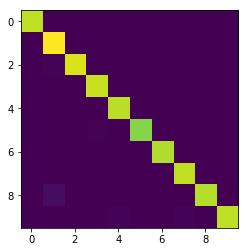

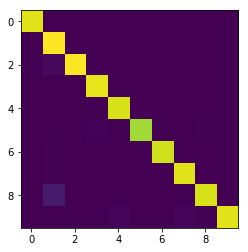

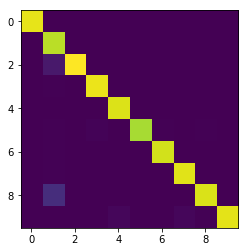

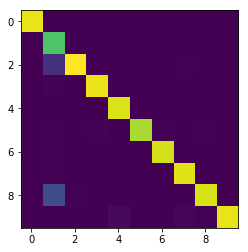

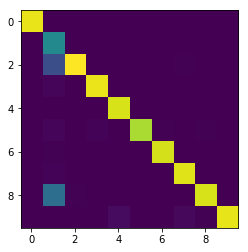

In [12]:
accuracies_bim = []
examples_bim = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, cf_mat = test_bim(model, device, test_loader, eps)
    plt.figure()
    plt.imshow(cf_mat)
    accuracies_bim.append(acc)
#     plt.imsave("cfmat_bim_{}.png".format(eps),cv2.resize(cf_mat,dsize=(256,256),interpolation=cv2.INTER_AREA))
    examples_bim.append(ex)


Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9576 / 10000 = 0.9576
Epsilon: 0.1	Test Accuracy = 9109 / 10000 = 0.9109
Epsilon: 0.15	Test Accuracy = 8288 / 10000 = 0.8288
Epsilon: 0.2	Test Accuracy = 7019 / 10000 = 0.7019
Epsilon: 0.25	Test Accuracy = 5272 / 10000 = 0.5272
Epsilon: 0.3	Test Accuracy = 3481 / 10000 = 0.3481


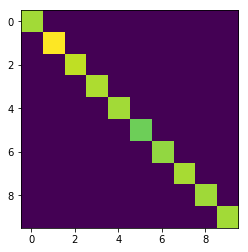

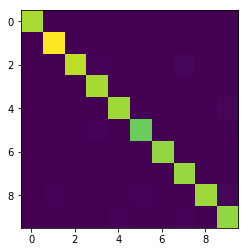

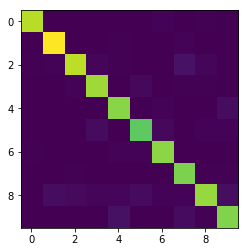

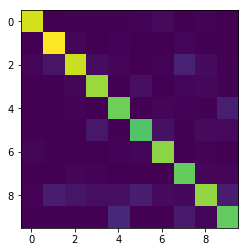

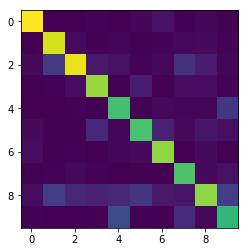

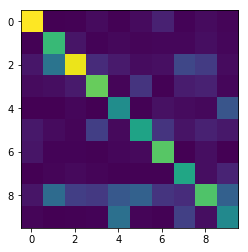

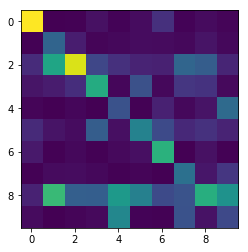

In [13]:
accuracies_pgd = []
examples_pgd = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, cf_mat = test_pgd(model, device, test_loader, eps)
    plt.figure()
    plt.imshow(cf_mat)
    accuracies_pgd.append(acc)
#     plt.imsave("cfmat_pgd_{}.png".format(eps),cv2.resize(cf_mat,dsize=(256,256),interpolation=cv2.INTER_AREA))
    examples_pgd.append(ex)

Results
-------

Accuracy vs Epsilon

The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.




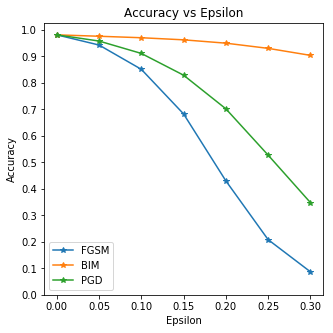

In [14]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_fgsm, "*-", label="FGSM")
plt.plot(epsilons, accuracies_bim, "*-", label="BIM")
plt.plot(epsilons, accuracies_pgd, "*-", label="PGD")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Comparison.png')
plt.show()

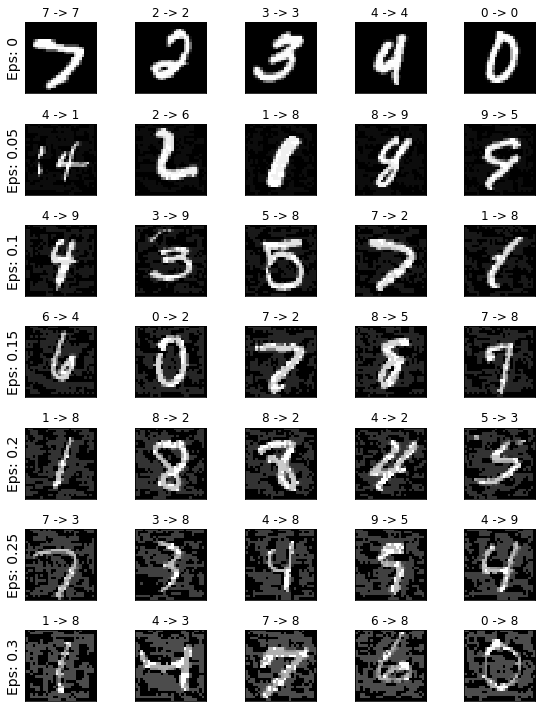

In [15]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_fgsm[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_fgsm[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_fgsm[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

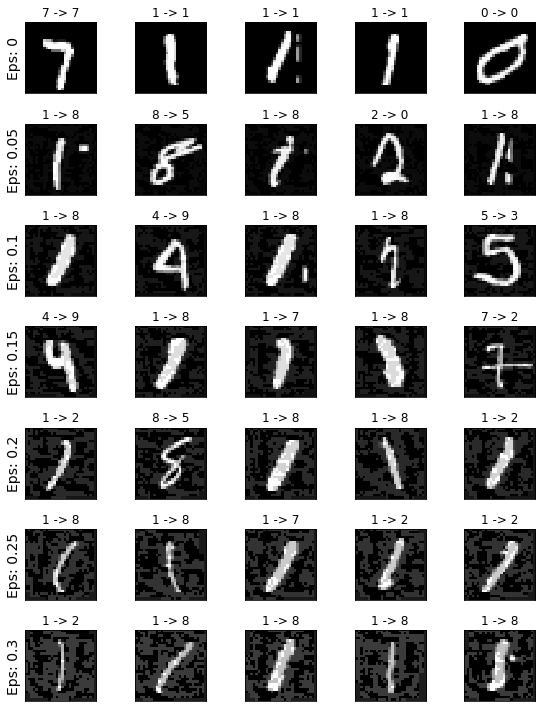

In [16]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_bim[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_bim[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_bim[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

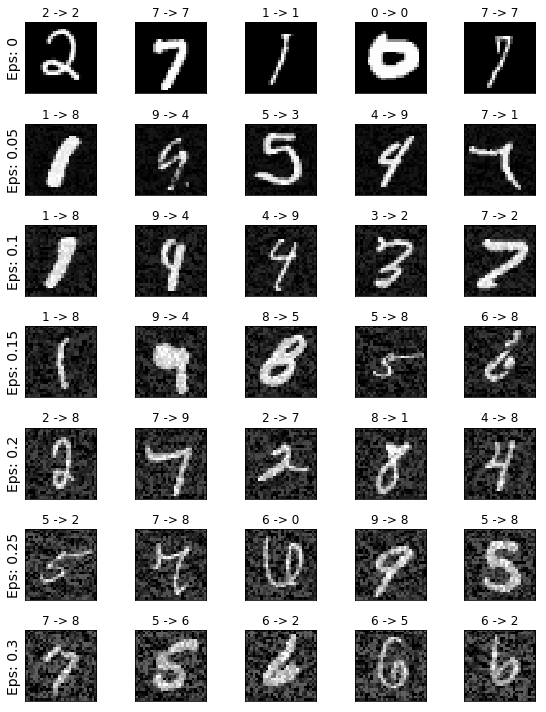

In [17]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_pgd[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_pgd[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_pgd[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()